seeding the reproductivity

In [1]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing dependcies

In [3]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

data curation

In [5]:
!pip install kaggle

In [7]:
kaggle_credentails = json.load(open("kaggle.json"))

In [8]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [9]:
! kaggle datasets download -d shashwatwork/identifying-disease-in-tea-leafs

 98% 725M/740M [00:10<00:00, 90.4MB/s]
100% 740M/740M [00:10<00:00, 75.5MB/s]


In [10]:
! ls

drive  identifying-disease-in-tea-leafs.zip  kaggle.json  sample_data


In [11]:
# Unzip the downloaded dataset
with ZipFile("identifying-disease-in-tea-leafs.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [12]:
! ls

 drive	 identifying-disease-in-tea-leafs.zip   kaggle.json   sample_data  'tea sickness dataset'


In [13]:
print(os.listdir("/content/tea sickness dataset"))

['red leaf spot', 'bird eye spot', 'brown blight', 'white spot', 'healthy', 'gray light', 'Anthracnose', 'algal leaf']


In [14]:
# Dataset Path
base_dir = 'tea sickness dataset'

(4160, 3120, 3)


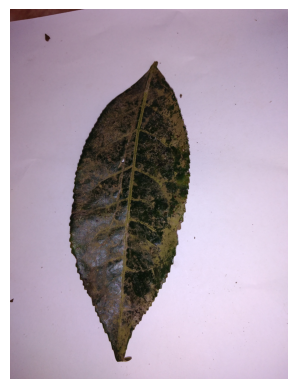

In [15]:
image_path = '/content/tea sickness dataset/Anthracnose/IMG_20220503_143433.jpg'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [16]:
# Image Parameters
img_size = 224
batch_size = 32

In [17]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [18]:
train_generator = data_gen.flow_from_directory(
    '/content/tea sickness dataset',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
)

Found 885 images belonging to 8 classes.


In [19]:
validation_generator = data_gen.flow_from_directory(
    '/content/tea sickness dataset',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
)

Found 174 images belonging to 8 classes.


CNN Model Training

In [20]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [22]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5
27/27 [==============================] - 137s 5s/step - loss: 5.4156 - accuracy: 0.3095 - val_loss: 1.1815 - val_accuracy: 0.4375
Epoch 2/5
27/27 [==============================] - 146s 5s/step - loss: 0.9422 - accuracy: 0.6178 - val_loss: 0.8390 - val_accuracy: 0.6438
Epoch 3/5
27/27 [==============================] - 140s 5s/step - loss: 0.6669 - accuracy: 0.7386 - val_loss: 0.5222 - val_accuracy: 0.8500
Epoch 4/5
27/27 [==============================] - 135s 5s/step - loss: 0.4461 - accuracy: 0.8441 - val_loss: 0.3006 - val_accuracy: 0.9000
Epoch 5/5
27/27 [==============================] - 133s 5s/step - loss: 0.4627 - accuracy: 0.8675 - val_loss: 0.2827 - val_accuracy: 0.9500


In [24]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
5/5 [==============================] - 11s 2s/step - loss: 0.2787 - accuracy: 0.9563
Validation Accuracy: 95.63%


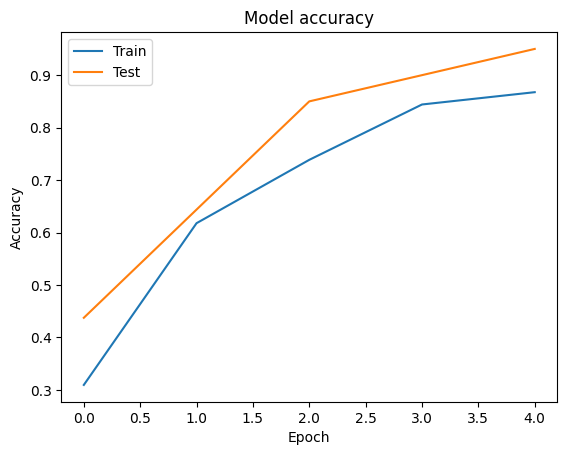

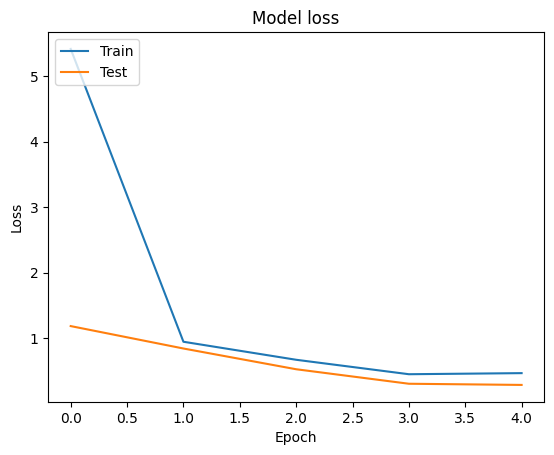

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [27]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [28]:
class_indices

{0: 'Anthracnose',
 1: 'algal leaf',
 2: 'bird eye spot',
 3: 'brown blight',
 4: 'gray light',
 5: 'healthy',
 6: 'red leaf spot',
 7: 'white spot'}

In [29]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [30]:
from google.colab import files
from PIL import Image
import IPython.display as display

1/1 [==============================] - 0s 53ms/step
Predicted Class Name: healthy


(-0.5, 767.5, 1023.5, -0.5)

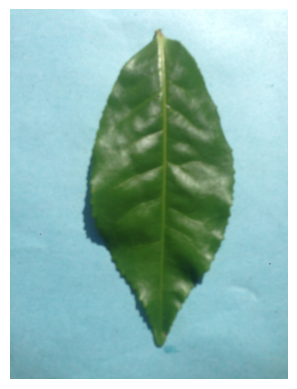

In [33]:
# Upload image file
#uploaded = files.upload()

# Get the first uploaded file
#file_keys = list(uploaded.keys())
#image_path = file_keys[0]

# Example Usage
#image_path = '/content/tea sickness dataset/gray light/IMG_20220503_135202.jpg'
image_path = '/content/tea sickness dataset/healthy/UNADJUSTEDNONRAW_thumb_20b.jpg'
#image_path = '/content/test_potato_early_blight.jpg'

predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis("off")

In [34]:
model.save("tealeavesdetection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
files.download('tealeavesdetection.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>